In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

Getting the UFC fighter data

In [2]:
df = pd.read_csv('ufc-master.csv')
df.head(5)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Rear Naked Choke,2.0,2:05,425.0,300.0,800.0,150.0,2500.0,400.0,350.0
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,5.0,5:00,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,NaN,3.0,5:00,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,Elbows,3.0,0:39,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,Elbows,3.0,3:21,801.0,275.0,550.0,500.0,700.0,300.0,250.0


In [3]:
df.isna().sum()

RedFighter             0
BlueFighter            0
RedOdds              227
BlueOdds             226
RedExpectedValue     227
                    ... 
BlueDecOdds         1116
RSubOdds            1336
BSubOdds            1359
RKOOdds             1334
BKOOdds             1360
Length: 118, dtype: int64

All the columns in the data set

In [4]:
for col in df.columns:
    print(col)

RedFighter
BlueFighter
RedOdds
BlueOdds
RedExpectedValue
BlueExpectedValue
Date
Location
Country
Winner
TitleBout
WeightClass
Gender
NumberOfRounds
BlueCurrentLoseStreak
BlueCurrentWinStreak
BlueDraws
BlueAvgSigStrLanded
BlueAvgSigStrPct
BlueAvgSubAtt
BlueAvgTDLanded
BlueAvgTDPct
BlueLongestWinStreak
BlueLosses
BlueTotalRoundsFought
BlueTotalTitleBouts
BlueWinsByDecisionMajority
BlueWinsByDecisionSplit
BlueWinsByDecisionUnanimous
BlueWinsByKO
BlueWinsBySubmission
BlueWinsByTKODoctorStoppage
BlueWins
BlueStance
BlueHeightCms
BlueReachCms
BlueWeightLbs
RedCurrentLoseStreak
RedCurrentWinStreak
RedDraws
RedAvgSigStrLanded
RedAvgSigStrPct
RedAvgSubAtt
RedAvgTDLanded
RedAvgTDPct
RedLongestWinStreak
RedLosses
RedTotalRoundsFought
RedTotalTitleBouts
RedWinsByDecisionMajority
RedWinsByDecisionSplit
RedWinsByDecisionUnanimous
RedWinsByKO
RedWinsBySubmission
RedWinsByTKODoctorStoppage
RedWins
RedStance
RedHeightCms
RedReachCms
RedWeightLbs
RedAge
BlueAge
LoseStreakDif
WinStreakDif
LongestWinStrea

In [5]:
ufc = df.copy()
winner_dict = {'Red': 1, 'Blue': 0}
ufc['Result'] = ufc['Winner'].map(winner_dict)

In [6]:
ufc.shape

(6528, 119)

# Investigating Betting Odds

Red Odds being less than Blue Odds means the Red fighter is favored to win and vice versa.

In [7]:
favored_and_won = ufc[((ufc['RedOdds'] > ufc['BlueOdds']) & (ufc['Result'] == 0)) 
                    | ((ufc['RedOdds'] < ufc['BlueOdds']) & (ufc['Result'] == 1))]
favored_and_lost = ufc[((ufc['RedOdds'] > ufc['BlueOdds']) & (ufc['Result'] == 1)) 
                    | ((ufc['RedOdds'] < ufc['BlueOdds']) & (ufc['Result'] == 0))]
display(len(favored_and_won))
display(len(favored_and_lost))

4091

2084

In [8]:
len(ufc[ufc['RedOdds'] < ufc['BlueOdds']]) / len(ufc)

0.5986519607843137

In [9]:
len(ufc[ufc['BlueOdds'] < ufc['RedOdds']]) / len(ufc)

0.3472732843137255

In [10]:
len(ufc[ufc['RedOdds'] == ufc['BlueOdds']]) / len(ufc)

0.01761642156862745

In [11]:
len(favored_and_won) / (len(favored_and_won) + len(favored_and_lost))

0.6625101214574899

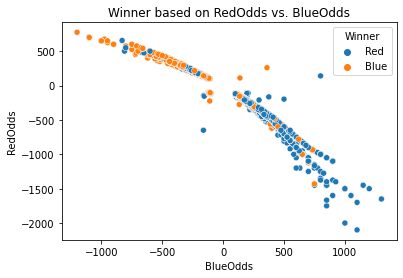

In [12]:
sns.scatterplot(data=ufc, x='BlueOdds', y='RedOdds', hue='Winner')
plt.title("Winner based on RedOdds vs. BlueOdds")
plt.show()

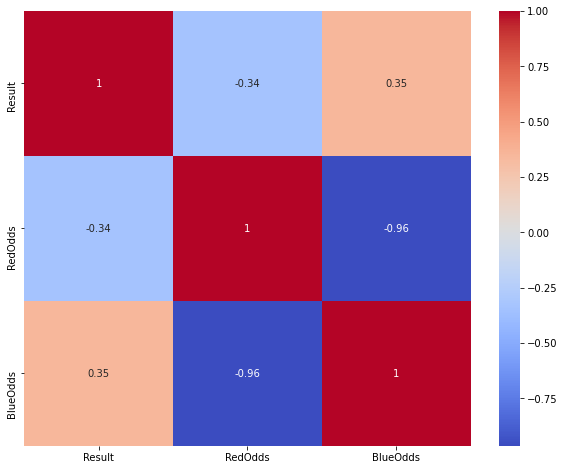

In [13]:
corr_matrix = ufc[['Result', 'RedOdds', 'BlueOdds']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [14]:
ufc['BlueStance'].value_counts()

BlueStance
Orthodox       4844
Southpaw       1274
Switch          405
Switch            1
Open Stance       1
Name: count, dtype: int64

In [15]:
ufc['BlueStance'] = ufc['BlueStance'].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [16]:
ufc['BlueStance'].value_counts()

BlueStance
Orthodox       4844
Southpaw       1274
Switch          406
Open Stance       1
Name: count, dtype: int64

In [17]:
ufc['RedStance'].value_counts()

RedStance
Orthodox       4877
Southpaw       1276
Switch          371
Open Stance       4
Name: count, dtype: int64

In [18]:
ufc_ages = ufc[['RedAge', 'BlueAge']]

In [19]:
ufc_ages.head(5)

,RedAge,BlueAge
0,34,31
1,30,27
2,34,36
3,30,36
4,36,33


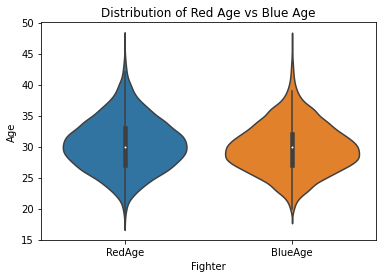

In [20]:
ufc_ages_melted = ufc_ages.melt(var_name='Fighter', value_name='Age')
sns.violinplot(data=ufc_ages_melted, x='Fighter', y='Age')
plt.title("Distribution of Red Age vs Blue Age")
plt.show()

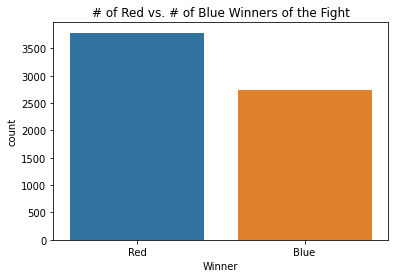

In [21]:
sns.countplot(data=ufc, x='Winner')
plt.title("# of Red vs. # of Blue Winners of the Fight")
plt.show()

# Wrestler vs. Strikers

In [22]:
ufc['BlueAvgTDLanded'].sort_values(ascending=False)

1938    10.86
1844    10.61
4419    10.00
6224    10.00
2566     9.93
        ...  
6506      NaN
6516      NaN
6523      NaN
6524      NaN
6526      NaN
Name: BlueAvgTDLanded, Length: 6528, dtype: float64

In [23]:
ufc['BlueAvgTDLanded'].describe()

count    5695.000000
mean        1.320536
std         1.356491
min         0.000000
25%         0.330000
50%         1.000000
75%         1.970000
max        10.860000
Name: BlueAvgTDLanded, dtype: float64

Let's use the 75% percentile (1.75) to classify a fighter as a wrestler or non-wrestler and see what we can find.

In [24]:
ufc['BlueWrestler'] = ufc['BlueAvgTDLanded'].apply(lambda x: 1 if x > 1.75 else 0)
ufc['RedWrestler'] = ufc['RedAvgTDLanded'].apply(lambda x: 1 if x > 1.75 else 0)

In [25]:
ufc_wrestler_win_vs_striker = ufc[
    ((ufc['BlueWrestler'] == 1) & (ufc['RedWrestler'] == 0) & (ufc['Result'] == 0)) |
    ((ufc['BlueWrestler'] == 0) & (ufc['RedWrestler'] == 1) & (ufc['Result'] == 1))
]

In [26]:
ufc_wrestler_win_vs_striker.head(5)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Result,BlueWrestler,RedWrestler
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0000,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,425.0,300.0,800.0,150.0,2500.0,400.0,350.0,1,0,1
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0000,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0,1,0,1
11,Michael Chiesa,Max Griffin,-130.0,110.0,76.9231,110.0000,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,716.0,200.0,200.0,350.0,1800.0,1600.0,350.0,1,0,1
20,Baergeng Jieleyisi,SuYoung You,190.0,-230.0,190.0000,43.4783,2024-11-23,"Macau, China",China,Blue,...,900.0,300.0,NaN,600.0,NaN,1100.0,NaN,0,1,0
27,Jon Jones,Stipe Miocic,-550.0,410.0,18.1818,410.0000,2024-11-16,"New York City, New York, USA",USA,Red,...,869.0,400.0,1400.0,200.0,3500.0,120.0,700.0,1,0,1


In [27]:
ufc_striker_win_vs_wrestler = ufc[
    ((ufc['BlueWrestler'] == 1) & (ufc['RedWrestler'] == 0) & (ufc['Result'] == 1)) |
    ((ufc['BlueWrestler'] == 0) & (ufc['RedWrestler'] == 1) & (ufc['Result'] == 0))
]

In [28]:
ufc_striker_win_vs_wrestler.head(5)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Result,BlueWrestler,RedWrestler
6,Vicente Luque,Themba Gorimbo,-650.0,-162.0,15.3846,61.7284,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,52.0,450.0,130.0,450.0,900.0,600.0,450.0,1,1,0
10,Cody Durden,Joshua Van,142.0,-170.0,142.0000,58.8235,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,900.0,300.0,250.0,550.0,800.0,900.0,225.0,0,0,1
12,Clay Guida,Chase Hooper,700.0,-1100.0,700.0000,9.0909,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,221.0,1200.0,225.0,2800.0,-165.0,2200.0,700.0,0,0,1
15,Yan Xiaonan,Tabatha Ricci,-198.0,164.0,50.5051,164.0000,2024-11-23,"Macau, China",China,Red,...,900.0,110.0,215.0,2000.0,1100.0,200.0,1800.0,1,1,0
23,Nyamjargal Tumendemberel,Carlos Hernandez,102.0,-122.0,102.0000,81.9672,2024-11-23,"Macau, China",China,Blue,...,900.0,450.0,130.0,500.0,400.0,600.0,1000.0,0,0,1


In [29]:
display(len(ufc_wrestler_win_vs_striker))
display(len(ufc_striker_win_vs_wrestler))

1356

1006

In [30]:
len(ufc_wrestler_win_vs_striker) / (len(ufc_wrestler_win_vs_striker) + len(ufc_striker_win_vs_wrestler))

0.5740897544453852

In [31]:
props = []
thresholds = []
num_wrestlers_per_threshold = []
ufc_temp = ufc.copy()
for threshold in np.arange(1, 3.5, 0.1):
    ufc_temp['BlueWrestler'] = ufc_temp['BlueAvgTDLanded'].apply(lambda x: 1 if x > threshold else 0)
    ufc_temp['RedWrestler'] = ufc_temp['RedAvgTDLanded'].apply(lambda x: 1 if x > threshold else 0)
    ufc_wrestler_win_vs_striker_temp = ufc_temp[
        ((ufc_temp['BlueWrestler'] == 1) & (ufc_temp['RedWrestler'] == 0) & (ufc_temp['Result'] == 0)) |
        ((ufc_temp['BlueWrestler'] == 0) & (ufc_temp['RedWrestler'] == 1) & (ufc_temp['Result'] == 1))
    ]
    ufc_striker_win_vs_wrestler_temp = ufc_temp[
        ((ufc_temp['BlueWrestler'] == 1) & (ufc_temp['RedWrestler'] == 0) & (ufc_temp['Result'] == 1)) |
        ((ufc_temp['BlueWrestler'] == 0) & (ufc_temp['RedWrestler'] == 1) & (ufc_temp['Result'] == 0))
    ]
    prop = len(ufc_wrestler_win_vs_striker_temp) / (len(ufc_wrestler_win_vs_striker_temp) + len(ufc_striker_win_vs_wrestler_temp))
    props.append(prop)
    thresholds.append(threshold)
    num_wrestlers_per_threshold.append(len(ufc_wrestler_win_vs_striker_temp))

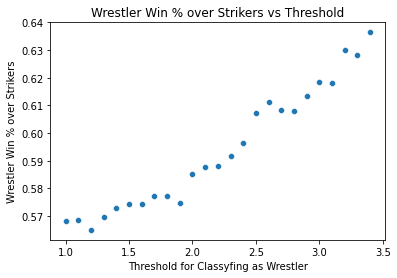

In [32]:
sns.scatterplot(x=thresholds, y=props)
plt.xlabel("Threshold for Classyfing as Wrestler")
plt.ylabel("Wrestler Win % over Strikers")
plt.title("Wrestler Win % over Strikers vs Threshold")
plt.show()

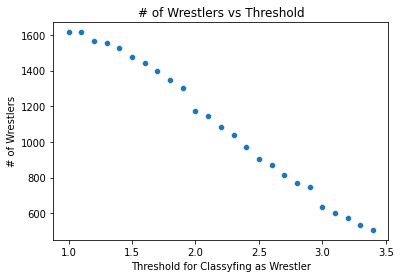

In [33]:
sns.scatterplot(x=thresholds, y=num_wrestlers_per_threshold)
plt.xlabel("Threshold for Classyfing as Wrestler")
plt.ylabel("# of Wrestlers")
plt.title("# of Wrestlers vs Threshold")
plt.show()

It seems that around a threshold of around 2 is a good way to label wrestlers since we get volume as well as accuracy for our future predictions.

In [34]:
ufc['BlueWrestler'] = ufc['BlueAvgTDLanded'].apply(lambda x: 1 if x > 2 else 0)
ufc['RedWrestler'] = ufc['RedAvgTDLanded'].apply(lambda x: 1 if x > 2 else 0)

# Reach/Height Advantage and How it Correlates with Significant Strikes

In [35]:
ufc_reach_height = ufc[['BlueHeightCms', 'BlueReachCms', 'BlueAvgSigStrLanded', 'RedHeightCms', 'RedReachCms', 'RedAvgSigStrLanded', 'HeightDif', 'ReachDif', 'SigStrDif', 'Winner']]
ufc_reach_height.head(5)

,BlueHeightCms,BlueReachCms,BlueAvgSigStrLanded,RedHeightCms,RedReachCms,RedAvgSigStrLanded,HeightDif,ReachDif,SigStrDif,Winner
0,172.72,175.26,0.00,165.10,170.18,4.41,7.62,5.08,-4.41,Red
1,190.50,187.96,5.50,185.42,195.58,4.12,5.08,-7.62,1.38,Red
2,200.66,203.20,5.13,193.04,205.74,5.49,7.62,-2.54,-0.36,Red
3,175.26,177.80,3.74,177.80,177.80,2.30,-2.54,0.00,1.44,Red
4,177.80,177.80,4.41,175.26,182.88,6.25,2.54,-5.08,-1.84,Blue


The difference's are calculated by taking the statistics for the red fighter and subtracting them from the blue fighter thus we can drop the redundant columns.

In [36]:
ufc_reach_height = ufc_reach_height.drop(columns=['BlueHeightCms', 'BlueReachCms', 'BlueAvgSigStrLanded', 'RedHeightCms', 'RedReachCms', 'RedAvgSigStrLanded'])
ufc_reach_height.head(5)

,HeightDif,ReachDif,SigStrDif,Winner
0,7.62,5.08,-4.41,Red
1,5.08,-7.62,1.38,Red
2,7.62,-2.54,-0.36,Red
3,-2.54,0.00,1.44,Red
4,2.54,-5.08,-1.84,Blue


In [37]:
ufc_height_adv = ufc_reach_height[((ufc_reach_height['HeightDif'] > 0) & (ufc_reach_height['Winner'] == 'Blue'))
                    | ((ufc_reach_height['HeightDif'] < 0) & (ufc_reach_height['Winner'] == 'Red'))
                 ]
ufc_reach_adv = ufc_reach_height[((ufc_reach_height['ReachDif'] > 0) & (ufc_reach_height['Winner'] == 'Blue'))
                    | ((ufc_reach_height['ReachDif'] < 0) & (ufc_reach_height['Winner'] == 'Red'))
                 ]
ufc_sigstr_adv = ufc_reach_height[((ufc_reach_height['SigStrDif'] > 0) & (ufc_reach_height['Winner'] == 'Blue'))
                    | ((ufc_reach_height['SigStrDif'] < 0) & (ufc_reach_height['Winner'] == 'Red'))
                 ]

In [38]:
len(ufc_height_adv) / len(ufc_reach_height)

0.43014705882352944

In [39]:
len(ufc_reach_adv) / len(ufc_reach_height)

0.4564950980392157

In [40]:
len(ufc_sigstr_adv) / len(ufc_reach_height)

0.5238970588235294

It seems that having a height/reach advantage does not give much indication of who will win the fight, but it might give an idea of who lands more significant strikes.

In [41]:
ufc_reach_height.drop(columns=['Winner'], inplace=True)

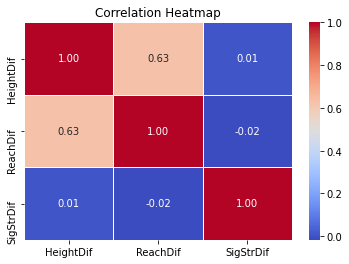

In [42]:
corr_matrix = ufc_reach_height.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

I would have thought that a reach advantage or height advantage would lead to more significant strikes, but it clearly has no impact on it nor on the outcome of the fight.

# Weight Discrepencies in the Data

In [43]:
ufc_weights = ufc[['BlueWeightLbs', 'RedWeightLbs', 'Winner', 'Date', 'WeightClass']]
ufc_weights.head(5)

,BlueWeightLbs,RedWeightLbs,Winner,Date,WeightClass
0,125,125,Red,2024-12-07,Flyweight
1,170,170,Red,2024-12-07,Welterweight
2,250,245,Red,2024-12-07,Heavyweight
3,145,145,Red,2024-12-07,Featherweight
4,145,145,Blue,2024-12-07,Featherweight


In [44]:
ufc_weights['WeightDif'] = ufc_weights['BlueWeightLbs'] - ufc_weights['RedWeightLbs']
ufc_weights.head(5)

<ipython-input-44-7c52c1208660>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ufc_weights['WeightDif'] = ufc_weights['BlueWeightLbs'] - ufc_weights['RedWeightLbs']


,BlueWeightLbs,RedWeightLbs,Winner,Date,WeightClass,WeightDif
0,125,125,Red,2024-12-07,Flyweight,0
1,170,170,Red,2024-12-07,Welterweight,0
2,250,245,Red,2024-12-07,Heavyweight,5
3,145,145,Red,2024-12-07,Featherweight,0
4,145,145,Blue,2024-12-07,Featherweight,0


In [45]:
ufc_weights['WeightDif'].value_counts()

WeightDif
 0     4731
-10     358
 10     315
-15     266
 15     216
       ... 
-11       1
 45       1
 31       1
-38       1
 75       1
Name: count, Length: 92, dtype: int64

In [46]:
ufc_weights['WeightDif'].abs().max()

80

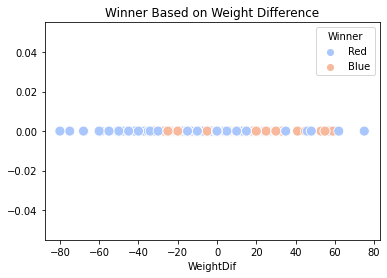

In [47]:
sns.scatterplot(data=ufc_weights, x='WeightDif', y=[0] * len(ufc_weights), hue='Winner', palette='coolwarm', s=100)
plt.title("Winner Based on Weight Difference")
plt.show()

In [48]:
ufc_weights.groupby('WeightClass')['WeightDif'].mean()

WeightClass
Bantamweight            -0.132548
Catch Weight            -0.819672
Featherweight           -0.066313
Flyweight                0.056657
Heavyweight             -1.250000
Light Heavyweight       -1.277445
Lightweight             -0.465549
Middleweight             0.006386
Welterweight            -0.565302
Women's Bantamweight    -0.610329
Women's Featherweight   -1.379310
Women's Flyweight       -0.083682
Women's Strawweight     -0.500000
Name: WeightDif, dtype: float64

In [49]:
ufc_weights[ufc_weights['WeightDif'] > 5]['WeightClass'].value_counts()

WeightClass
Heavyweight              169
Middleweight             114
Lightweight              112
Featherweight             94
Welterweight              78
Bantamweight              52
Flyweight                 44
Light Heavyweight         39
Women's Bantamweight      30
Women's Flyweight         19
Women's Strawweight       16
Catch Weight               5
Women's Featherweight      1
Name: count, dtype: int64

There were some crazy weight differences throughout UFC history, but most of these differences are in the heavyweight division thus usually has no value in predicting UFC fights today.

# Creating the Logistic Regression Model

In [50]:
for col in ufc.columns:
    print(col)

RedFighter
BlueFighter
RedOdds
BlueOdds
RedExpectedValue
BlueExpectedValue
Date
Location
Country
Winner
TitleBout
WeightClass
Gender
NumberOfRounds
BlueCurrentLoseStreak
BlueCurrentWinStreak
BlueDraws
BlueAvgSigStrLanded
BlueAvgSigStrPct
BlueAvgSubAtt
BlueAvgTDLanded
BlueAvgTDPct
BlueLongestWinStreak
BlueLosses
BlueTotalRoundsFought
BlueTotalTitleBouts
BlueWinsByDecisionMajority
BlueWinsByDecisionSplit
BlueWinsByDecisionUnanimous
BlueWinsByKO
BlueWinsBySubmission
BlueWinsByTKODoctorStoppage
BlueWins
BlueStance
BlueHeightCms
BlueReachCms
BlueWeightLbs
RedCurrentLoseStreak
RedCurrentWinStreak
RedDraws
RedAvgSigStrLanded
RedAvgSigStrPct
RedAvgSubAtt
RedAvgTDLanded
RedAvgTDPct
RedLongestWinStreak
RedLosses
RedTotalRoundsFought
RedTotalTitleBouts
RedWinsByDecisionMajority
RedWinsByDecisionSplit
RedWinsByDecisionUnanimous
RedWinsByKO
RedWinsBySubmission
RedWinsByTKODoctorStoppage
RedWins
RedStance
RedHeightCms
RedReachCms
RedWeightLbs
RedAge
BlueAge
LoseStreakDif
WinStreakDif
LongestWinStrea

In [51]:
columns = ['RedOdds', 
           'BlueOdds',
           'WinDif',
           'LossDif',
           'SigStrDif',
           'AvgSubAttDif',
           'AvgTDDif',
           'BlueWrestler',
           'RedWrestler',
           'Result'
          ]
ufc_new = ufc[columns]

In [52]:
ufc_new.shape

(6528, 10)

In [53]:
ufc_new.isna().sum()

RedOdds         227
BlueOdds        226
WinDif            0
LossDif           0
SigStrDif         0
AvgSubAttDif      0
AvgTDDif          0
BlueWrestler      0
RedWrestler       0
Result            0
dtype: int64

In [54]:
ufc_new = ufc_new.fillna(0)

In [55]:
ufc_new.isna().sum()

RedOdds         0
BlueOdds        0
WinDif          0
LossDif         0
SigStrDif       0
AvgSubAttDif    0
AvgTDDif        0
BlueWrestler    0
RedWrestler     0
Result          0
dtype: int64

In [56]:
ufc_new.head(5)

,RedOdds,BlueOdds,WinDif,LossDif,SigStrDif,AvgSubAttDif,AvgTDDif,BlueWrestler,RedWrestler,Result
0,-250.0,215.0,-12,-3,-4.41,-0.8,-2.61,0,1,1
1,-210.0,295.0,2,0,1.38,-1.5,-0.72,0,0,1
2,-380.0,300.0,3,2,-0.36,-0.3,-0.13,0,0,1
3,-950.0,625.0,-6,0,1.44,-1.1,-2.98,0,1,1
4,-130.0,110.0,-1,0,-1.84,-0.2,-0.25,0,0,0


In [57]:
ufc_new.columns

Index(['RedOdds', 'BlueOdds', 'WinDif', 'LossDif', 'SigStrDif', 'AvgSubAttDif',
       'AvgTDDif', 'BlueWrestler', 'RedWrestler', 'Result'],
      dtype='object')

In [58]:
X = ufc_new.drop(columns=['Result'])
y = ufc_new['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=45)

lm = LogisticRegression()
lm.fit(X_train, y_train)

/Users/lakshaysoin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [59]:
pred_train = lm.predict(X_train)
np.sum(pred_train == y_train) / len(y_train)

0.6512830333205668

In [60]:
pred_test = lm.predict(X_test)
np.sum(pred_test == y_test) / len(y_test)

0.6837672281776417

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test)
cm

array([[296, 257],
       [156, 597]])

# Creating an ELO Rating System

In [62]:
ufc.head(5)

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds,Result,BlueWrestler,RedWrestler
0,Alexandre Pantoja,Kai Asakura,-250.0,215.0,40.0000,215.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,425.0,300.0,800.0,150.0,2500.0,400.0,350.0,1,0,1
1,Shavkat Rakhmonov,Ian Machado Garry,-210.0,295.0,47.6190,295.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,1500.0,250.0,650.0,180.0,3000.0,240.0,700.0,1,0,0
2,Ciryl Gane,Alexander Volkov,-380.0,300.0,26.3158,300.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,900.0,-160.0,450.0,1100.0,3000.0,350.0,1100.0,1,0,0
3,Bryce Mitchell,Kron Gracie,-950.0,625.0,10.5263,625.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Red,...,639.0,-200.0,1100.0,380.0,1400.0,500.0,4000.0,1,0,1
4,Nate Landwehr,Dooho Choi,-130.0,110.0,76.9231,110.0,2024-12-07,"Las Vegas, Nevada, USA",USA,Blue,...,801.0,275.0,550.0,500.0,700.0,300.0,250.0,0,0,0


In [63]:
for col in ufc.columns:
    print(col)

RedFighter
BlueFighter
RedOdds
BlueOdds
RedExpectedValue
BlueExpectedValue
Date
Location
Country
Winner
TitleBout
WeightClass
Gender
NumberOfRounds
BlueCurrentLoseStreak
BlueCurrentWinStreak
BlueDraws
BlueAvgSigStrLanded
BlueAvgSigStrPct
BlueAvgSubAtt
BlueAvgTDLanded
BlueAvgTDPct
BlueLongestWinStreak
BlueLosses
BlueTotalRoundsFought
BlueTotalTitleBouts
BlueWinsByDecisionMajority
BlueWinsByDecisionSplit
BlueWinsByDecisionUnanimous
BlueWinsByKO
BlueWinsBySubmission
BlueWinsByTKODoctorStoppage
BlueWins
BlueStance
BlueHeightCms
BlueReachCms
BlueWeightLbs
RedCurrentLoseStreak
RedCurrentWinStreak
RedDraws
RedAvgSigStrLanded
RedAvgSigStrPct
RedAvgSubAtt
RedAvgTDLanded
RedAvgTDPct
RedLongestWinStreak
RedLosses
RedTotalRoundsFought
RedTotalTitleBouts
RedWinsByDecisionMajority
RedWinsByDecisionSplit
RedWinsByDecisionUnanimous
RedWinsByKO
RedWinsBySubmission
RedWinsByTKODoctorStoppage
RedWins
RedStance
RedHeightCms
RedReachCms
RedWeightLbs
RedAge
BlueAge
LoseStreakDif
WinStreakDif
LongestWinStrea

In [64]:
ufc[['BlueFighter', 'RedFighter', 'BMatchWCRank', 'RMatchWCRank', 'TitleBout']]

,BlueFighter,RedFighter,BMatchWCRank,RMatchWCRank,TitleBout
0,Kai Asakura,Alexandre Pantoja,NaN,0.0,True
1,Ian Machado Garry,Shavkat Rakhmonov,7.0,3.0,False
2,Alexander Volkov,Ciryl Gane,3.0,2.0,False
3,Kron Gracie,Bryce Mitchell,NaN,13.0,False
4,Dooho Choi,Nate Landwehr,NaN,NaN,False
...,...,...,...,...,...
6523,Darren Elkins,Duane Ludwig,NaN,NaN,False
6524,Daniel Roberts,John Howard,NaN,NaN,False
6525,Chase Gormley,Brendan Schaub,NaN,NaN,False
6526,Julio Paulino,Mike Pierce,NaN,NaN,False


In [65]:
fighters = []
for red in ufc['RedFighter']:
    if (red not in fighters):
        fighters.append(red)
for blue in ufc['BlueFighter']:
    if (blue not in fighters):
        fighters.append(blue)
ratings = {}
for fighter in fighters:
    ufc_red_fighter = ufc[(ufc['RedFighter'] == fighter)]
    ufc_blue_fighter = ufc[(ufc['BlueFighter'] == fighter)]
    r1 = 3 * ufc_red_fighter['Result'].sum() + 5 * np.sum(20 - ufc_red_fighter[ufc_red_fighter['Result'] == 1]['BMatchWCRank'].fillna(15)) + 8 * len(ufc_red_fighter[ufc_red_fighter['TitleBout'] == True]) + 15 * len(ufc_red_fighter[ufc_red_fighter['Result'] == 1]['TitleBout'] == True)
    r2 = 3 * ufc_blue_fighter['Result'].sum() + 5 * np.sum(20 - ufc_blue_fighter[ufc_blue_fighter['Result'] == 0]['RMatchWCRank'].fillna(15)) + 8 * len(ufc_blue_fighter[ufc_blue_fighter['TitleBout'] == True]) + 15 * len(ufc_blue_fighter[ufc_blue_fighter['Result'] == 0]['TitleBout'] == True)
    rating = r1 + r2
    ratings[fighter] = rating
ratings

{'Alexandre Pantoja': 965.0,
 'Shavkat Rakhmonov': 442.0,
 'Ciryl Gane': 781.0,
 'Bryce Mitchell': 381.0,
 'Nate Landwehr': 221.0,
 'Dominick Reyes': 408.0,
 'Vicente Luque': 735.0,
 'Movsar Evloev': 485.0,
 'Randy Brown': 550.0,
 'Chris Weidman': 861.0,
 'Cody Durden': 261.0,
 'Michael Chiesa': 674.0,
 'Clay Guida': 577.0,
 'Kennedy Nzechukwu': 350.0,
 'Petr Yan': 680.0,
 'Yan Xiaonan': 518.0,
 'Song Kenan': 258.0,
 'Wang Cong': 43.0,
 'Volkan Oezdemir': 621.0,
 'Zhang Mingyang': 86.0,
 'Baergeng Jieleyisi': 0.0,
 'Kiru Sahota': 0.0,
 'Shi Ming': 43.0,
 'Nyamjargal Tumendemberel': 0.0,
 "Lone'er Kavanagh": 43.0,
 'Xiao Long': 43.0,
 'Maheshate': 86.0,
 'Jon Jones': 1529.0,
 'Charles Oliveira': 1381.0,
 'Bo Nickal': 172.0,
 'Viviane Araujo': 448.0,
 'Mauricio Ruffy': 86.0,
 'Jonathan Martinez': 423.0,
 'Jim Miller': 961.0,
 'David Onama': 215.0,
 'Marcin Tybura': 679.0,
 'Mickey Gall': 264.0,
 'Bassil Hafez': 43.0,
 'Veronica Hardy': 123.0,
 'Neil Magny': 1062.0,
 'Gerald Meerschaert':

In [66]:
sorted_dict_desc = dict(sorted(ratings.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict_desc)

{'Max Holloway': 1781.0, 'Jon Jones': 1529.0, 'Amanda Nunes': 1450.0, 'Charles Oliveira': 1381.0, 'Jessica Andrade': 1378.0, 'Valentina Shevchenko': 1336.0, 'Dustin Poirier': 1334.0, 'Rafael Dos Anjos': 1261.0, 'Donald Cerrone': 1261.0, 'Demetrious Johnson': 1261.0, 'Stipe Miocic': 1256.0, 'Israel Adesanya': 1248.0, 'Robert Whittaker': 1229.0, 'Aljamain Sterling': 1224.0, 'Kamaru Usman': 1213.0, 'Alexander Volkanovski': 1172.0, 'Jose Aldo': 1159.0, 'TJ Dillashaw': 1146.0, 'Derrick Lewis': 1136.0, 'Rose Namajunas': 1081.0, 'Daniel Cormier': 1072.0, 'Neil Magny': 1062.0, 'Joseph Benavidez': 1055.0, 'Deiveson Figueiredo': 1049.0, 'Curtis Blaydes': 1011.0, 'Glover Teixeira': 1004.0, 'Khabib Nurmagomedov': 981.0, 'Joanna Jedrzejczyk': 968.0, 'Alexandre Pantoja': 965.0, 'Jim Miller': 961.0, 'Francis Ngannou': 951.0, 'Edson Barboza': 947.0, 'Brandon Moreno': 943.0, 'Robbie Lawler': 942.0, 'Tony Ferguson': 933.0, 'Raquel Pennington': 928.0, 'Leon Edwards': 928.0, 'Belal Muhammad': 927.0, 'Demi

In [68]:
ufc_new['RedELO'] = ufc['RedFighter'].map(ratings)
ufc_new['BlueELO'] = ufc['BlueFighter'].map(ratings)
ufc_new.head(5)

,RedOdds,BlueOdds,WinDif,LossDif,SigStrDif,AvgSubAttDif,AvgTDDif,BlueWrestler,RedWrestler,Result,RedELO,BlueELO
0,-250.0,215.0,-12,-3,-4.41,-0.8,-2.61,0,1,1,965.0,11.0
1,-210.0,295.0,2,0,1.38,-1.5,-0.72,0,0,1,442.0,269.0
2,-380.0,300.0,3,2,-0.36,-0.3,-0.13,0,0,1,781.0,820.0
3,-950.0,625.0,-6,0,1.44,-1.1,-2.98,0,1,1,381.0,46.0
4,-130.0,110.0,-1,0,-1.84,-0.2,-0.25,0,0,0,221.0,215.0


In [69]:
X = ufc_new.drop(columns=['Result'])
y = ufc_new['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=45)

lm = LogisticRegression()
lm.fit(X_train, y_train)

/Users/lakshaysoin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [70]:
pred_train = lm.predict(X_train)
np.sum(pred_train == y_train) / len(y_train)

0.763692072003064

In [71]:
pred_test = lm.predict(X_test)
np.sum(pred_test == y_test) / len(y_test)

0.7756508422664625

In [72]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_test)
cm

array([[385, 168],
       [125, 628]])

# Function to process and test new data

In [73]:
def create_ratings():
    fighters = []
    for red in ufc['RedFighter']:
        if (red not in fighters):
            fighters.append(red)
    for blue in ufc['BlueFighter']:
        if (blue not in fighters):
            fighters.append(blue)
    ratings = {}
    for fighter in fighters:
        ufc_red_fighter = ufc[(ufc['RedFighter'] == fighter)]
        ufc_blue_fighter = ufc[(ufc['BlueFighter'] == fighter)]
        r1 = 3 * ufc_red_fighter['Result'].sum() + 5 * np.sum(20 - ufc_red_fighter[ufc_red_fighter['Result'] == 1]['BMatchWCRank'].fillna(15)) + 8 * len(ufc_red_fighter[ufc_red_fighter['TitleBout'] == True]) + 15 * len(ufc_red_fighter[ufc_red_fighter['Result'] == 1]['TitleBout'] == True)
        r2 = 3 * ufc_blue_fighter['Result'].sum() + 5 * np.sum(20 - ufc_blue_fighter[ufc_blue_fighter['Result'] == 0]['RMatchWCRank'].fillna(15)) + 8 * len(ufc_blue_fighter[ufc_blue_fighter['TitleBout'] == True]) + 15 * len(ufc_blue_fighter[ufc_blue_fighter['Result'] == 0]['TitleBout'] == True)
        rating = r1 + r2
        ratings[fighter] = rating
    return ratings

In [74]:
ratings = create_ratings()

In [75]:
def process(df):
    df['BlueWrestler'] = ufc['BlueAvgTDLanded'].apply(lambda x: 1 if x > 2 else 0)
    df['RedWrestler'] = ufc['RedAvgTDLanded'].apply(lambda x: 1 if x > 2 else 0)
    columns = ['RedOdds', 
           'BlueOdds',
           'WinDif',
           'LossDif',
           'SigStrDif',
           'AvgSubAttDif',
           'AvgTDDif',
           'BlueWrestler',
           'RedWrestler',
           'RedFighter',
           'BlueFighter'
          ]
    X = df[columns]
    X['RedELO'] = X['RedFighter'].map(ratings)
    X['BlueELO'] = X['BlueFighter'].map(ratings)
    X = X.drop(['RedFighter', 'BlueFighter'], axis=1)
    X = X.fillna(0)
    display(X)
    pred = lm.predict(X)
    return pred

# Testing on data for an upcoming fight

In [76]:
upcoming = pd.read_csv('upcoming.csv')
upcoming

,RedFighter,BlueFighter,RedOdds,BlueOdds,RedExpectedValue,BlueExpectedValue,Date,Location,Country,Winner,...,FinishDetails,FinishRound,FinishRoundTime,TotalFightTimeSecs,RedDecOdds,BlueDecOdds,RSubOdds,BSubOdds,RKOOdds,BKOOdds
0,Colby Covington,Joaquin Buckley,205,-250,205.0000,40.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,300,175.0,1800,2000.0,1100,150.0
1,Cub Swanson,Billy Quarantillo,124,-148,124.0000,67.5676,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,250,NaN,1800,NaN,450,NaN
2,Manel Kape,Bruno Silva,-395,310,25.3165,310.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,-105,550.0,900,1800.0,225,1100.0
3,Vitor Petrino,Dustin Jacoby,-340,270,29.4118,270.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,240,500.0,550,3000.0,110,800.0
4,Adrian Yanez,Daniel Marcos,185,-225,185.0000,44.4444,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,450,150.0,2200,2200.0,450,200.0
5,Navajo Stirling,Tuco Tokkos,-750,525,13.3333,525.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,275,1000.0,1200,2500.0,-185,1200.0
6,Michael Johnson,Ottman Azaitar,-230,190,43.4783,190.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,300,650.0,1000,2500.0,120,350.0
7,Joel Alvarez,Drakkar Klose,-425,330,23.5294,330.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,240,650.0,165,3000.0,275,900.0
8,Sean Woodson,Fernando Padilla,-155,130,64.5161,130.0000,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,100,350.0,2000,650.0,550,500.0
9,Miles Johns,Felipe Lima,210,-258,210.0000,38.7597,2024-12-14,"Tampa, Florida, USA",USA,NaN,...,NaN,NaN,NaN,NaN,350,-110.0,2000,650.0,700,500.0


In [77]:
upcoming_preds = process(upcoming)
upcoming_preds

<ipython-input-75-9640c78fbdac>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['RedELO'] = X['RedFighter'].map(ratings)
<ipython-input-75-9640c78fbdac>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['BlueELO'] = X['BlueFighter'].map(ratings)


,RedOdds,BlueOdds,WinDif,LossDif,SigStrDif,AvgSubAttDif,AvgTDDif,BlueWrestler,RedWrestler,RedELO,BlueELO
0,205,-250,-2,0,0.25,-0.2,-1.83,0,1,829.0,474.0
1,124,-148,-12,-9,2.69,0.7,0.20,0,0,763.0,264.0
2,-395,310,0,-1,-1.12,-0.2,1.72,0,0,205.0,349.0
3,-340,270,3,5,2.68,-0.8,-3.62,0,1,175.0,310.0
4,185,-225,-3,-2,-0.57,0.0,0.25,0,0,261.0,120.0
5,-750,525,-1,2,-3.81,0.0,1.96,0,0,0.0,3.0
6,-230,190,-12,-13,1.46,0.0,-0.62,1,0,698.0,89.0
7,-425,330,3,0,-0.02,-1.2,1.58,1,1,255.0,335.0
8,-155,130,-5,0,0.90,0.4,-0.66,0,0,249.0,83.0
9,210,-258,-6,-2,0.01,1.3,0.31,0,1,249.0,40.0


array([1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [78]:
true_vals = [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0]
true_vals = np.array(true_vals)

In [79]:
np.sum(upcoming_preds == true_vals) / len(true_vals)

0.6153846153846154

In [80]:
betting_odds = [0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]
betting_odds = np.array(betting_odds)

In [81]:
np.sum(true_vals == betting_odds) / len(betting_odds)

0.7692307692307693

# Classification with XGBoost

In [115]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
setattr(pd, "Int64Index", pd.Index)

In [119]:
X = ufc_new.drop(columns=['Result'])
y = ufc_new['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=45)

In [120]:
learning_rate_range = np.arange(0.01, 0.96, 0.05)
test_XG = []
train_XG = []

for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta=lr, random_state=45, use_label_encoder=False)
    xgb_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    
    train_preds = xgb_classifier.predict(X_train)
    test_preds = xgb_classifier.predict(X_test)
    
    train_XG.append(accuracy_score(y_train, train_preds))
    test_XG.append(accuracy_score(y_test, test_preds))

print("Training Accuracies:", train_XG)
print("Testing Accuracies:", test_XG)

[16:45:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:45:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

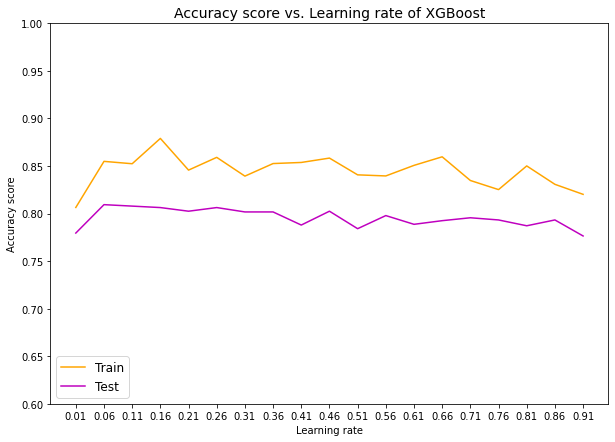

In [121]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0.6, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()